## Import IMDB dataset

In [ ]:
import torch
import pandas as pd
import nltk
nltk.download('punkt')

def download_file_from_gdrive(url, pathXX, output_name=False):
  var1 = url.split("/")[5]
  %cd $pathXX
  if output_name==False:
    !gdown $var1
  else:
    out = pathXX + output_name
    !gdown $var1 -O $out
  %cd '/content'

path = '/content'
csv_file_name = '/example2.xlsm'

url = 'https://drive.google.com/file/d/1t5f333SlKjAp4hrJt7yd6vBpa4xaw26c/view?usp=drive_link'

download_file_from_gdrive(url, path, output_name=csv_file_name)

df = pd.read_csv(path + csv_file_name)

In [4]:
import torch
import pandas as pd
import nltk
df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


## Since the time is limited we will try only half of the dataset

In [6]:
sentences = []

for idx, text in enumerate(df['review']):
    if idx == 25000: break
    text_processed = nltk.word_tokenize(text)
    text_processed = [token.lower() for token in text_processed]
    sentences.append(text_processed)

In [7]:
print(sentences[0])

['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'ll", 'be', 'hooked', '.', 'they', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', '.', 'trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', '.', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', '.', 'its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', '.', 

In [8]:
labels = df.loc[:24999, ['sentiment']].values.tolist()
labels = [l[0] for l in labels]

In [9]:
print('Positive labels: ', labels.count('positive'))
print('Negative labels: ', labels.count('negative'))

Positive labels:  12474
Negative labels:  12526


## Split the dataset into: train, valid, test

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, train_size=0.8, test_size=0.2, random_state=666, shuffle=True)
train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(train_sentences, train_labels, train_size=0.8, test_size=0.2, random_state=666, shuffle=True)
print('Number of train:', len(train_sentences))
print('Number of valid:', len(valid_sentences))
print('Number of test:', len(test_sentences))

Number of train: 16000
Number of valid: 4000
Number of test: 5000


## Preprocessing: word2vec model

In [11]:
import gensim
import torch
from gensim.models import Word2Vec

word_emb_dim = 128
embedding_model = gensim.models.word2vec.Word2Vec(train_sentences, vector_size=word_emb_dim, min_count=1)
weights = torch.FloatTensor(embedding_model.wv.vectors) # can be used for nn.Embedding.from_pretrained(weights)

In [12]:
print('Vocab size:',len(embedding_model.wv))
print('Vocab: good')
print(embedding_model.wv['good'])

Vocab size: 89604
Vocab: good
[ 1.1331729   0.7442602  -0.78041095 -0.39027193 -1.5486224   1.2551028
 -0.903204    1.0860358   2.3495257   3.0210757  -1.234893   -0.31895626
  1.3064848   0.30992335 -1.89763     2.6376822  -0.20230359 -0.07143996
  2.1453857   1.2425797  -1.3284959   1.3279736  -1.0921719  -1.2870896
 -1.6045653   0.41627654 -1.7427745   1.6985307  -1.048278    0.42726782
 -1.863057   -1.8245738  -2.6353111  -0.49325308 -0.39034626  0.64110774
 -0.3205525  -0.8461578   1.0252419   0.64720213 -3.3991172  -1.8768293
 -0.00825014 -0.98135597  0.6601056   0.62314546 -1.4024781  -0.6742314
  0.9410692   3.0448437  -0.88494366 -3.9876716   0.29727405 -1.5251865
 -0.39300022 -0.4058619  -0.69772696  0.97110975 -1.9032001   0.03671354
 -0.17333525 -0.23250581 -0.07626086  0.3099408   0.2291894  -2.0161426
  1.7830098  -0.6811503   0.76731473  0.2280888   0.1271003  -1.6581157
  1.7020217  -0.56240505  0.54727286  1.9625556   1.4272823   0.67814034
 -0.2909348   1.9490021   0.

"<PAD>"## Indexing the text <br>
Ex: <br>
word index === word === word embedding <br>
0 === "\<PAD\>"' === [0.0,  0.0, ...,  0.0] <br>
63 === "good" === [-0.48092350363731384, 1.6767021417617798, ...]

In [15]:
idx2word = ["<PAD>"] + ["<UNK>"] + list(embedding_model.wv.key_to_index)
word2idx = {u:i for i, u in enumerate(idx2word)}

idx2label = ['negative','positive']
label2idx = {u:i for i, u in enumerate(idx2label)}

idx2embed = [[0.0] * word_emb_dim] + [[0.5] * word_emb_dim] + embedding_model.wv[embedding_model.wv.key_to_index].tolist()
idx2embed = {idx:embed for idx, embed in enumerate(idx2embed)}

In [16]:
print(word2idx['good'], idx2embed[word2idx['good']])
print(label2idx)

63 [1.133172869682312, 0.7442601919174194, -0.7804109454154968, -0.390271931886673, -1.5486223697662354, 1.2551027536392212, -0.9032040238380432, 1.0860358476638794, 2.3495256900787354, 3.02107572555542, -1.2348929643630981, -0.31895625591278076, 1.3064848184585571, 0.30992335081100464, -1.897629976272583, 2.6376821994781494, -0.20230358839035034, -0.0714399591088295, 2.1453857421875, 1.242579698562622, -1.3284958600997925, 1.3279736042022705, -1.0921719074249268, -1.2870895862579346, -1.6045652627944946, 0.4162765443325043, -1.742774486541748, 1.698530673980713, -1.0482779741287231, 0.42726781964302063, -1.863057017326355, -1.8245737552642822, -2.6353111267089844, -0.49325308203697205, -0.3903462588787079, 0.6411077380180359, -0.3205524981021881, -0.8461577892303467, 1.0252418518066406, 0.6472021341323853, -3.3991172313690186, -1.8768292665481567, -0.008250136859714985, -0.9813559651374817, 0.6601055860519409, 0.6231454610824585, -1.4024780988693237, -0.6742314100265503, 0.94106918573

In [17]:
print(word2idx["<PAD>"], idx2embed[word2idx["<PAD>"]])
print(word2idx["<UNK>"], idx2embed[word2idx["<UNK>"]])

0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

## featureVecMethod: Generate sentence embedding, that is, the word vector (word embedding) of each word (token) in the average sentence
## Note: This method using "average" to generate sentence embedding is too simple, sometimes it is not a good practice, and the effect is limited

In [18]:
def featureVecMethod(sentence):
    featureVec = np.zeros(word_emb_dim, dtype="float32")
    num_words = len(sentence)

    for word_idx in sentence:
        featureVec = np.add(featureVec, idx2embed[word_idx])

    featureVec = np.divide(featureVec, num_words)
    return featureVec

## Each word (token) in the sentence is mapped to the word index, and the sentence embedding of each sentence is generated using featureVecMethod

## Convert sentence labels to label index


In [19]:
train_sentences_as_index = [[word2idx["<UNK>"] if word not in word2idx else word2idx[word] for word in sentence] for sentence in train_sentences]
train_sentences_as_embed = [featureVecMethod(sentence) for sentence in train_sentences_as_index]
train_labels_as_index= [label2idx[label] for label in train_labels]

valid_sentences_as_index = [[word2idx["<UNK>"] if word not in word2idx else word2idx[word] for word in sentence] for sentence in valid_sentences]
valid_sentences_as_embed = [featureVecMethod(sentence) for sentence in valid_sentences_as_index]
valid_labels_as_index= [label2idx[label] for label in valid_labels]

test_sentences_as_index = [[word2idx["<UNK>"] if word not in word2idx else word2idx[word] for word in sentence] for sentence in test_sentences]
test_sentences_as_embed = [featureVecMethod(sentence) for sentence in test_sentences_as_index]
test_labels_as_index= [label2idx[label] for label in test_labels]

## Sentence embedding

In [20]:
len(train_sentences_as_embed[0]), train_sentences_as_embed[0]

(128,
 array([-0.68445637,  0.77835786,  0.28058911, -0.35734316, -0.31145128,
         0.05152991,  0.33568277, -0.46274022,  0.58464202,  1.01989279,
        -1.19452357, -0.32824691,  0.73471843, -0.28986164, -0.44546042,
         0.33596009, -0.56518345,  0.09119878, -0.58921919,  0.55158513,
         0.19692018,  0.43019603, -0.56669847, -0.51455969, -1.22815165,
         0.53617679, -0.9436453 ,  0.30730084, -0.09943439, -0.0227692 ,
        -0.98791171, -0.36138572, -0.91161795,  0.33904174, -0.56480513,
         0.42991101,  0.26731004, -0.70022155,  0.68753568,  0.01978482,
        -0.96810363, -0.28470382, -0.79735017,  0.01796626,  0.56649702,
        -0.06579953, -0.71555608, -0.30695886, -0.47032965,  0.01125961,
        -0.25033075, -0.48683933,  0.30762496,  0.09399638,  0.31613472,
        -0.64817305, -0.06695537,  0.58206337, -0.26738638,  0.22667764,
        -0.19950151,  0.53837989,  0.58406191,  0.34335568,  0.35974778,
        -0.78198793, -0.57839141, -0.083499  

## Dataset

In [21]:
from torch.utils.data.dataset import Dataset

class ImdbDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.sentences[index]), torch.tensor(self.labels[index])

    def __len__(self):
        return len(self.sentences)

In [22]:
train_dataset = ImdbDataset(train_sentences_as_embed, train_labels_as_index)
valid_dataset = ImdbDataset(valid_sentences_as_embed, valid_labels_as_index)
test_dataset = ImdbDataset(test_sentences_as_embed, test_labels_as_index)

In [36]:
print(train_dataset[0][0].shape)
train_dataset[0]

torch.Size([128])


(tensor([-0.6845,  0.7784,  0.2806, -0.3573, -0.3115,  0.0515,  0.3357, -0.4627,
          0.5846,  1.0199, -1.1945, -0.3282,  0.7347, -0.2899, -0.4455,  0.3360,
         -0.5652,  0.0912, -0.5892,  0.5516,  0.1969,  0.4302, -0.5667, -0.5146,
         -1.2282,  0.5362, -0.9436,  0.3073, -0.0994, -0.0228, -0.9879, -0.3614,
         -0.9116,  0.3390, -0.5648,  0.4299,  0.2673, -0.7002,  0.6875,  0.0198,
         -0.9681, -0.2847, -0.7974,  0.0180,  0.5665, -0.0658, -0.7156, -0.3070,
         -0.4703,  0.0113, -0.2503, -0.4868,  0.3076,  0.0940,  0.3161, -0.6482,
         -0.0670,  0.5821, -0.2674,  0.2267, -0.1995,  0.5384,  0.5841,  0.3434,
          0.3597, -0.7820, -0.5784, -0.0835,  0.0211,  0.2639,  0.1081,  0.3057,
         -0.1331,  0.4212,  0.0489,  0.0921,  0.1234, -0.4132, -0.1368,  0.6403,
         -0.0613,  0.2199,  0.2222,  0.2565,  0.4078,  0.5288, -0.0016, -0.7805,
          0.7497,  0.5566,  0.2693,  1.0577, -0.1637,  0.3173,  0.7495,  0.4705,
         -0.3778,  0.2481,  

## DataLoader (for batching dataset)

In [24]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    sentence_tensors = [s[0] for s in samples]
    label_ids = torch.stack([s[1] for s in samples])

    sentence_tensors = pad_sequence(sentence_tensors, batch_first=True)
    return sentence_tensors, label_ids

In [25]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch, shuffle=False)

## The example of batch sentences

In [26]:
data = next(iter(train_loader))
print(data)

(tensor([[-0.3424,  0.5820,  0.3943,  ..., -0.2183, -0.2894, -0.0114],
        [-0.7232,  0.6992,  0.4726,  ..., -0.3447, -0.1077, -0.0511],
        [-0.5182,  0.6638,  0.2313,  ..., -0.2719, -0.3856,  0.0085],
        ...,
        [-0.2728,  0.6989,  0.1571,  ..., -0.2463, -0.5152,  0.0655],
        [-0.4538,  0.3757,  0.3930,  ..., -0.2866, -0.2185, -0.1298],
        [-0.5303,  0.6227,  0.3133,  ..., -0.0802, -0.3729,  0.1307]],
       dtype=torch.float64), tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]))


In [27]:
data[0].shape, data[1].shape

(torch.Size([64, 128]), torch.Size([64]))

## Build model <br>
## Hint: fill in fc_units, out_units, out_in, out_out

In [28]:
!nvidia-smi

Sat Aug  5 14:16:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   31C    P8     6W / 198W |      2MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:17:00.0 Off |                  N/A |
|  0%   

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [38]:
import torch.nn as nn

class IMDBModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(128, 128) # [word_emb_dim, out_features]
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1) # [out_features, 1]
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        x = self.fc(x) # [word_emb_dim, out_features]
        x = self.relu(x)

        x = self.out(x) # [out_features, 1]
        y = self.out_act(x) # [out_features, 1]
        return y

## Example model output

In [39]:
model = IMDBModel()
output = model(data[0])
print(output)
print(torch.stack([p[0] for p in output])) # stack predictions

tensor([[0.5337],
        [0.5569],
        [0.5352],
        [0.5196],
        [0.5160],
        [0.5272],
        [0.5221],
        [0.5295],
        [0.5328],
        [0.5220],
        [0.5342],
        [0.5467],
        [0.5438],
        [0.5226],
        [0.5184],
        [0.5359],
        [0.5458],
        [0.5285],
        [0.5538],
        [0.5405],
        [0.5223],
        [0.5254],
        [0.5409],
        [0.5387],
        [0.5195],
        [0.5565],
        [0.5489],
        [0.5440],
        [0.5268],
        [0.5477],
        [0.5215],
        [0.5411],
        [0.5308],
        [0.5334],
        [0.5354],
        [0.5167],
        [0.5098],
        [0.5483],
        [0.5383],
        [0.5520],
        [0.5392],
        [0.5327],
        [0.5394],
        [0.5450],
        [0.5147],
        [0.5381],
        [0.5548],
        [0.5345],
        [0.5452],
        [0.5333],
        [0.5235],
        [0.5189],
        [0.5318],
        [0.5200],
        [0.5197],
        [0

## Training & Evaliation

In [40]:
def accuracy(predictions, label_ids):
    prediction_ids = torch.round(predictions)
    correct = (prediction_ids == label_ids).sum().item()
    total = label_ids.size(0)
    acc = correct / total
    return acc

In [41]:
def train(train_loader):
    model.train()
    running_loss = 0
    running_acc = 0

    for batch, data in enumerate(train_loader):
        sentence_tensors, label_ids = [t.to(device) for t in data]
        predictions = model(sentence_tensors)
        predictions = torch.stack([p[0] for p in predictions])

        # gradient
        optimizer.zero_grad()
        loss = loss_criterion(predictions.float(), label_ids.float())
        loss.backward()
        optimizer.step()

        # metric
        acc = accuracy(predictions, label_ids)


        running_loss += loss.item()
        running_acc += acc
        if batch % 50 == 0 and batch != 0:
            print('Batch {} Loss {:.4f} Acc {:.4f}'.format(batch, running_loss / batch, running_acc / batch))

    print('Training done! Loss {:.4f} Acc {:.4f}\n'.format(running_loss / len(train_loader), running_acc / len(train_loader)))
    return running_loss / len(train_loader), running_acc / len(train_loader)


In [42]:
def evaluate(valid_loader):
    model.eval()
    running_loss = 0
    running_acc = 0

    with torch.no_grad():
        for batch, data in enumerate(valid_loader):
            sentence_tensors, label_ids = [t.to(device) for t in data]
            predictions = model(sentence_tensors)
            predictions = torch.stack([p[0] for p in predictions])

            # gradient
            loss = loss_criterion(predictions.float(), label_ids.float())

            # metric
            acc = accuracy(predictions, label_ids)


            running_loss += loss.item()
            running_acc += acc

        print('Evaluate done! Loss {:.4f} Acc {:.4f}\n'.format(running_loss / len(valid_loader), running_acc / len(valid_loader)))
    return running_loss / len(valid_loader), running_acc / len(valid_loader)

In [43]:
import time

learning_rate = 1e-3
EPOCH = 50

model = IMDBModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.BCELoss()

train_loss_ls = []
train_acc_ls = []
valid_loss_ls = []
valid_acc_ls = []

for epoch in range(EPOCH):
    start = time.time()
    print('Epoch {} start!'.format(epoch+1))

    train_loss, train_acc = train(train_loader)
    train_loss_ls.append(train_loss)
    train_acc_ls.append(train_acc)

    valid_loss, valid_acc = evaluate(valid_loader)
    valid_loss_ls.append(valid_loss)
    valid_acc_ls.append(valid_acc)

    print('Time taken for Epoch {}: {} secs\n'.format(epoch+1, time.time() - start))
    print('='*100)

Epoch 1 start!
Batch 50 Loss 0.6672 Acc 0.6500
Batch 100 Loss 0.6381 Acc 0.6648
Batch 150 Loss 0.6124 Acc 0.6881
Batch 200 Loss 0.5883 Acc 0.7050
Training done! Loss 0.5669 Acc 0.7161

Evaluate done! Loss 0.4907 Acc 0.7696

Time taken for Epoch 1: 6.69126033782959 secs

Epoch 2 start!
Batch 50 Loss 0.4914 Acc 0.7963
Batch 100 Loss 0.4817 Acc 0.7919
Batch 150 Loss 0.4781 Acc 0.7900
Batch 200 Loss 0.4729 Acc 0.7896
Training done! Loss 0.4695 Acc 0.7852

Evaluate done! Loss 0.4629 Acc 0.7795

Time taken for Epoch 2: 1.1266999244689941 secs

Epoch 3 start!
Batch 50 Loss 0.4678 Acc 0.8006
Batch 100 Loss 0.4628 Acc 0.7939
Batch 150 Loss 0.4625 Acc 0.7939
Batch 200 Loss 0.4562 Acc 0.7971
Training done! Loss 0.4509 Acc 0.7934

Evaluate done! Loss 0.4804 Acc 0.7631

Time taken for Epoch 3: 2.367347002029419 secs

Epoch 4 start!
Batch 50 Loss 0.4474 Acc 0.8153
Batch 100 Loss 0.4447 Acc 0.8048
Batch 150 Loss 0.4440 Acc 0.8020
Batch 200 Loss 0.4390 Acc 0.8037
Training done! Loss 0.4394 Acc 0.7978


## Plot loss and accuracy of train and validation

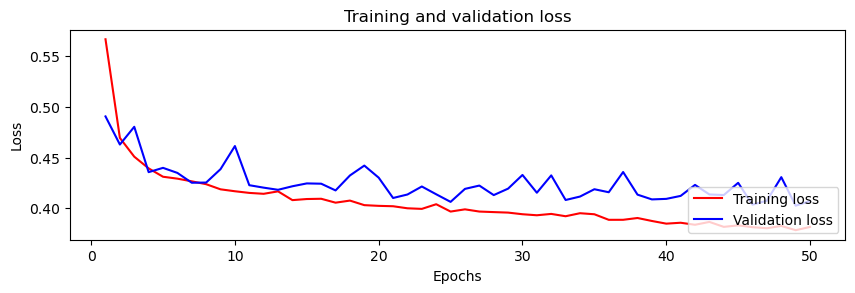

In [44]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCH+1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_loss_ls, 'r', label='Training loss')
plt.plot(epochs, valid_loss_ls, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

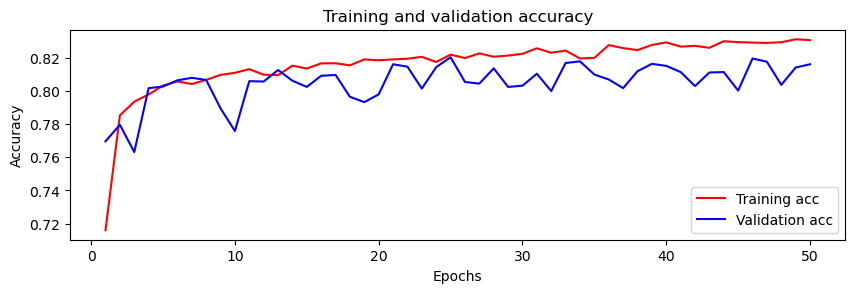

In [45]:
epochs = range(1, EPOCH+1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_ls, 'r', label='Training acc')
plt.plot(epochs, valid_acc_ls, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Prediction

In [46]:
test_loss, test_acc = evaluate(test_loader)

Evaluate done! Loss 0.4301 Acc 0.8157

